# Makemore MLP

Here we will be building a model similar to the one described in [Bengio et al 2003](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

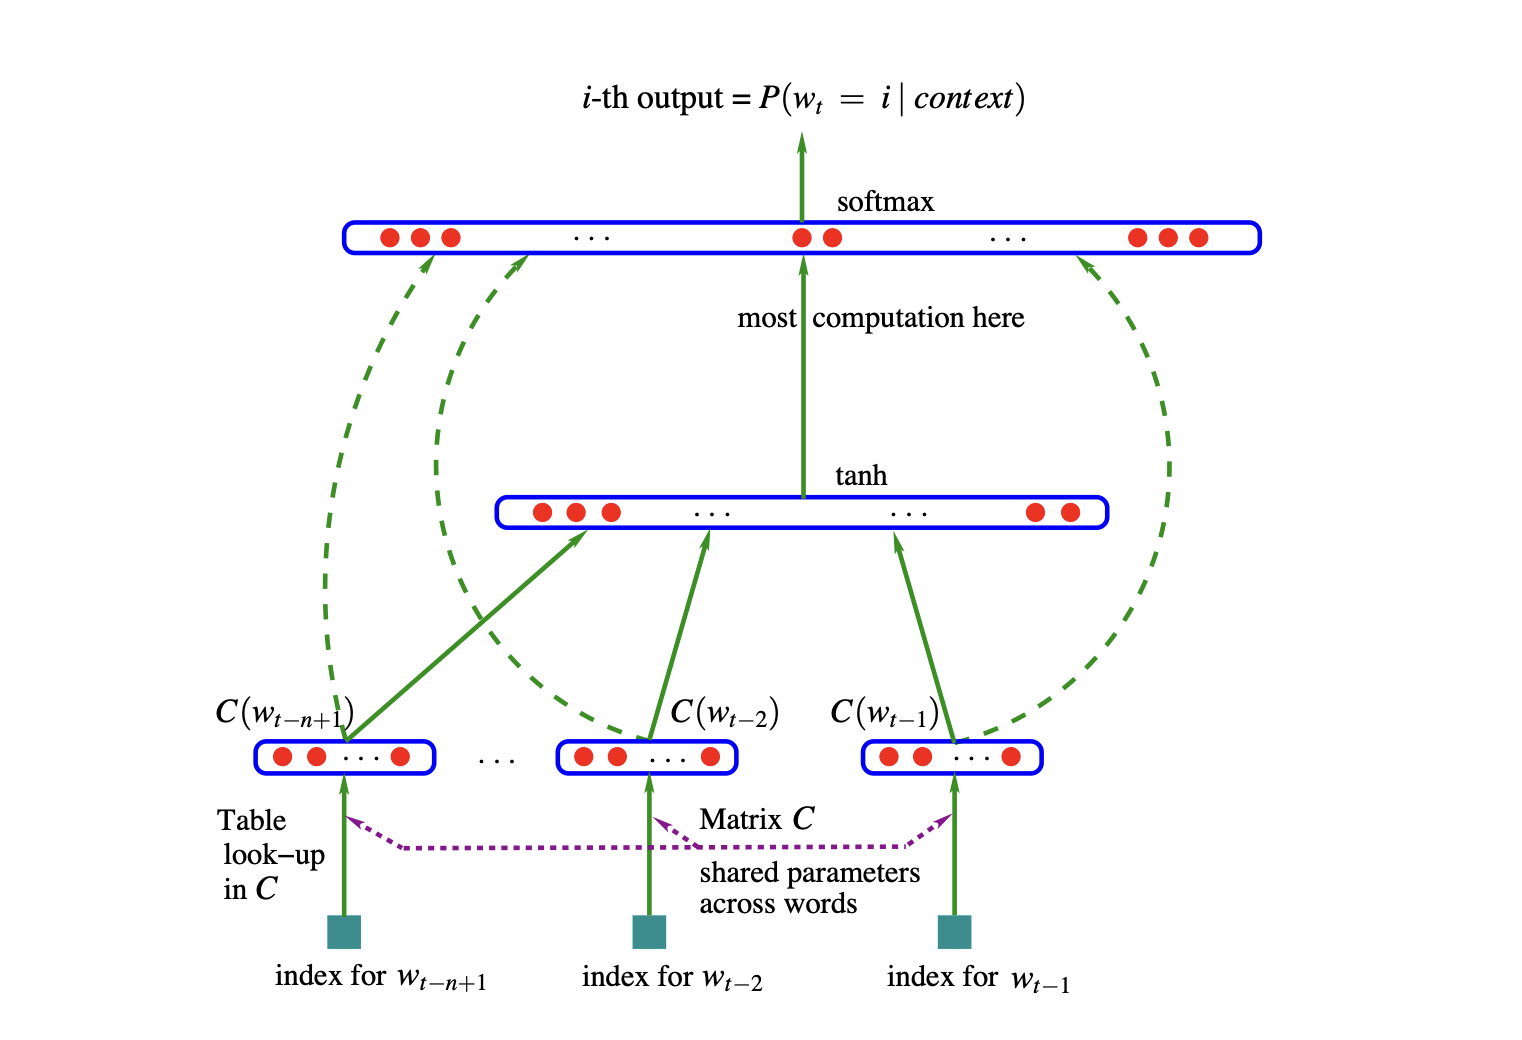


In [1]:
#Imports
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt #for making figures
%matplotlib inline

In [2]:
#Read in all the words
words = open('../data/names.txt').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
#Size of our dataset
len(words)

32033

In [ ]:
#Build stoi and itos lookup tables
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [27]:
#Build a dataset of 5 examples for the neural network

block_size = 3 #context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:5]:

    print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] #crop and append
    print('\n')
X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .


olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .


ava
... ---> a
..a ---> v
.av ---> a
ava ---> .


isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .


sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .




In [10]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [11]:
# Initialize character -> embedding lookup table
C = torch.randn((27,2))

In [12]:
# Two equivalent ways to lookup a character embedding.
# However torch optimizes indexing so we will do that moving forward.
C[5] == F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([True, True])

In [13]:
#Passing X, a (32,3) tensor of values between 0 and 26, to C, our (27,2) lookup table tensor produces a new tensor of (32,3,2) - the same shape as x but each entry now a pair of 2d coordinates.
embeds = C[X]
embeds.shape

torch.Size([32, 3, 2])

In [14]:
#Initialize weights from embeddings to size 100 hidden layer
W1 = torch.randn((6,100))
b1 = torch.randn(100)

In [15]:
#We have our (32,3,2) block (::: x 32 deep) but we want a sheet (...... x 32 deep)
#We can do this by slicing (:|:|: x 32 deep) but need to specify the index along which we want to stick the pieces together - (: x 96 deep) or (...... x 32 deep). We want the latter so we say index 1.
torch.cat([embeds[:,0,:], embeds[:,1,:],embeds[:,2,:]], 1).shape

torch.Size([32, 6])

In [16]:
#Torch has sugar for this ::: -> [:,:,:] sort of slicing called 'unbind'
torch.cat(torch.unbind(embeds,1), 1).shape

torch.Size([32, 6])

In [17]:
#Turns out, **none** of this is actually necessary, you can just call view().
#This is because under the hood, torch stores all the numbers in a single list and structural information separately, making this sort of casting extremely fast
embeds.view(32,6) == torch.cat(torch.unbind(embeds,1), 1)

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

See this [blog post](https://blog.ezyang.com/2019/05/pytorch-internals/) on torch's internals for more details

In [18]:
#Calculate hidden layer from embeds + weights
hidden = torch.tanh(embeds.view(-1,6) @ W1 + b1)

In [19]:
#Initialize weights between hidden layer and log-counts layer
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [20]:
#Calculate log-counts layer from hidden layer + weights
logits = hidden @ W2 + b2

In [21]:
#Calculate counts from log-counts
counts = logits.exp()

In [22]:
#Normalize counts into probabilities
prob = counts / counts.sum(1,keepdim=True)

In [23]:
#Verify probabilities are of shape (N_examples,alphabet_size)
prob.shape

torch.Size([32, 27])

In [24]:
#Calculate average negative log likelihood loss
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(17.5100)

In [26]:
# The loss function we've been using has a name: cross-entropy
# torch has a built in function for this, which is preferable since we can differentiate through it analytically thereby reducing the size of the computation graph
# It's also a lot more numerically well-behaved as raw exp() quickly saturates the dynamic range of floats.
F.cross_entropy(logits, Y)

tensor(17.5100)

### Putting it all together

In [ ]:
#Build the full dataset

block_size = 3 #context length
X, Y = [], []
for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] #crop and append
X = torch.tensor(X)
Y = torch.tensor(Y)

In [30]:
#Size of full dataset
X.shape,Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [35]:
#Initialize network parameters
g = torch.Generator().manual_seed(6789998212)
C = torch.randn((27,2),generator=g)
W1 = torch.randn((6,100),generator=g)
b1 = torch.randn(100,generator=g)
W2 = torch.randn((100,27),generator=g)
b2 = torch.randn(27,generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [32]:
#Count number of parameters in network
sum(p.nelement() for p in parameters)

3481

### Aside: Mini-batching

Rather than calculate the gradient over the entire training set, we will only use small random subsets to reduce the compute cost. With mini-batches the quality of the gradient approximation is lower but it is much better "value for money" so to speak. It is "right enough" to get you where you need to go much more cheaply.

In [43]:
#Generate 32 random indicies from the training set
torch.randint(0,X.shape[0],(32,))

tensor([ 94841, 186440,  79410, 178524, 171290,  45058, 164216,  87076,  80129,
         94673, 132412, 199996,  77291,  15793, 133508, 226303, 150502,  65241,
         37982,  21912, 184528, 222243,  70726, 165405, 117412,  32060, 118551,
         30163,  86703,  28287,  12268, 146942])

In [ ]:
#Train our neural network

# lri=[]
# lossi=[]

for i in range(10000):

    #minibatch of size 32
    ix = torch.randint(0, X.shape[0], (32,))

    #forward pass
    embeds = C[X[ix]]
    hidden = torch.tanh(embeds.view(-1,6) @ W1 + b1)
    logits = hidden @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix]) #loss *for* the mini-batch

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    # lr = lrs[i]
    # lr = 0.1 #Initial rate
    lr = 0.01 #Factor of 10 learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    # lri.append(lre[i])
    # lossi.append(loss.item())

print(loss.item()) #loss on final mini-batch

2.6818461418151855


In [ ]:
#Full training set loss
embeds = C[X]
hidden = torch.tanh(embeds.view(-1,6) @ W1 + b1)
logits = hidden @ W2 + b2
loss = F.cross_entropy(logits, Y)
print(loss.item())

7.428639888763428


### Experiment: Learning rate

In [34]:
#Create sample of learning rate exponents to try
lre = torch.linspace(-3,0,1000)
lrs = 10**lre

In [39]:
#Re-initialize network parameters
g = torch.Generator().manual_seed(6789998212)
C = torch.randn((27,2),generator=g)
W1 = torch.randn((6,100),generator=g)
b1 = torch.randn(100,generator=g)
W2 = torch.randn((100,27),generator=g)
b2 = torch.randn(27,generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [ ]:
#Run our learning rate experiment 

lri=[]
lossi=[]

for i in range(1000):

    #minibatch of size 32
    ix = torch.randint(0, X.shape[0], (32,))

    #forward pass
    embeds = C[X[ix]]
    hidden = torch.tanh(embeds.view(-1,6) @ W1 + b1)
    logits = hidden @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix]) #loss *for* the minibatch

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    lri.append(lre[i])
    lossi.append(loss.item())

print(loss.item())

7.199098587036133


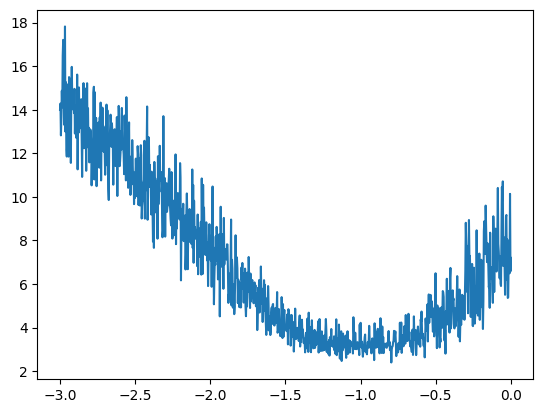

In [41]:
#plot the exponent of the learning rate to find optimal rate
plt.plot(lri,lossi)

Turns out -0.1 was a good guess after all!

### Visualizing the 2D embeddings

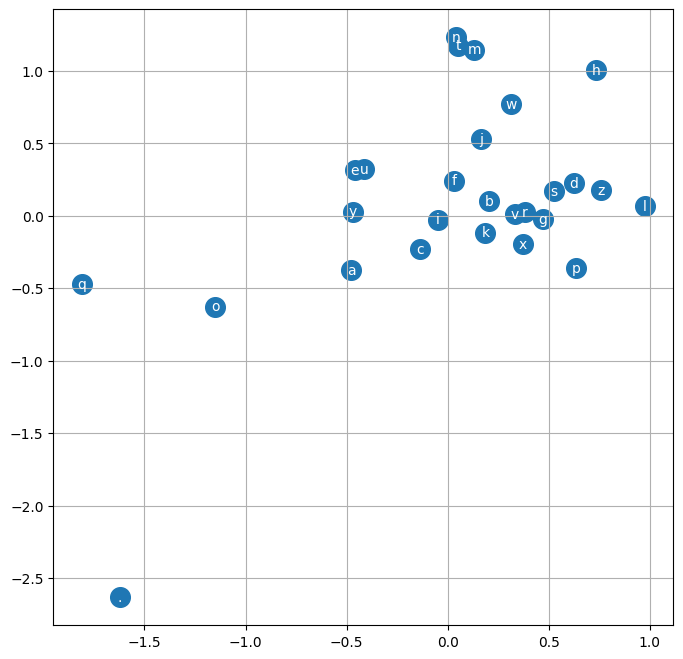

In [42]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data,C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

### Train,Test,Validation/Dev Split
80,10,10 is typical

Validation/Dev is used to tune hyperparameters (hidden layer size, embedding size,etc.)

In [47]:
# Build train, dev, and test datasets

def build_dataset(words, context_length = 3):
    X, Y = [], []
    for w in words:

        # print(w)
        context = [0] * context_length
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] #crop and append
        # print('\n')
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random 
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


In [48]:
#Initialize network parameters

g = torch.Generator().manual_seed(6789998212) #for reproducability

#Architectural hyperparameters
embed_dims = 10
context_length = 3
hl_size = 200

#Model parameters
C = torch.randn((27,embed_dims),generator=g)
W1 = torch.randn((embed_dims*context_length,hl_size),generator=g)
b1 = torch.randn(hl_size,generator=g)
W2 = torch.randn((hl_size,27),generator=g)
b2 = torch.randn(27,generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [49]:
sum(p.nelement() for p in parameters)

11897

In [ ]:
#Train on the training split

#Training Hyperparameters
# learning_rate (set dynamically below)
batch_size = 32

lossi=[]
stepi = []

for i in range(200000):

    #generate minibatch indices
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))

    #forward pass
    embeds = C[Xtr[ix]]
    hidden = torch.tanh(embeds.view(-1,embed_dims*context_length) @ W1 + b1)
    logits = hidden @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix]) #loss *for* the minibatch

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    learning_rate = 0.1 if i < 100000 else 0.01 #Factor of 10 learning rate decay
    for p in parameters:
        p.data += -learning_rate * p.grad

    #track stats
    stepi.append(i)
    lossi.append(loss.log10().item())

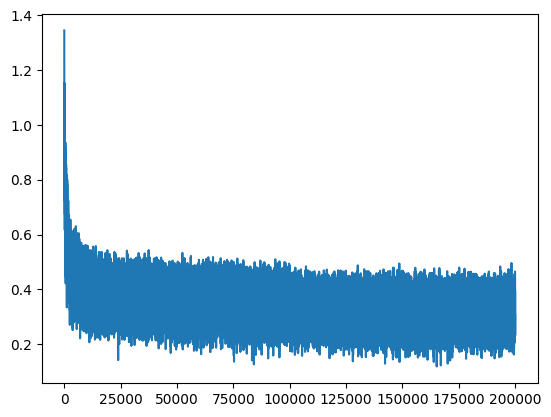

In [51]:
#Plot training progress
plt.plot(stepi, lossi)

In [52]:
#Evaluate the full training loss
embeds = C[Xtr]
hidden = torch.tanh(embeds.view(-1,embed_dims*context_length) @ W1 + b1)
logits = hidden @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print(loss.item())

2.110140323638916


In [53]:
#Evaluate the dev loss
embeds = C[Xdev]
hidden = torch.tanh(embeds.view(-1,embed_dims*context_length) @ W1 + b1)
logits = hidden @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.1619348526000977


If Ltr and Ldev are the same, we know we are not overfitting. Until we see evidence of overfitting, we know we can extract improvements from our model.

# Exercises

Run experiments on any of the following hyperparameters to beat this performance:
- Hidden layer size
- Embedding dimension
- Context length
- Training epochs
- Learning rate
- Learning rate decay
- Batch size

### Sampling from the model

In [ ]:
g = torch.Generator().manual_seed(6789998212)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        # forward pass the neural net
        embeds = C[torch.tensor(context)]
        hidden = torch.tanh(embeds.view(1,-1) @ W1 + b1)
        logits = hidden @ W2 + b2
        probs = F.softmax(logits,dim=1)
        #sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        #shift the context window and append the sample
        context = context[1:] + [ix]
        out.append(ix)
        #if we sample the specail '.' token, stop
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

westreya.
kassi.
avda.
khatalin.
aridy.
caliyah.
sose.
day.
ivea.
citon.
halaidenora.
calee.
akelidenavelia.
trace.
frydon.
raz.
tzanahani.
veryna.
joui.
akeva.
